In [1]:
import pandas as pd
import random
from datetime import datetime, timedelta

sefer_df = pd.read_csv("SEFER_LIST.csv")
passenger_df = pd.read_csv("UPDATED_PASSENGER_LIST.csv")

def evaluate_fitness(passenger_df_base: pd.DataFrame, sefer_times: pd.DataFrame, max_capacity: int = 950) -> float:
    passenger_df = passenger_df_base.copy()
    sefer_df = sefer_times.copy()

    passenger_df["enterance_time"] = pd.to_datetime(passenger_df["enterance_time"], format="%H:%M:%S").dt.time
    for col in sefer_df.columns:
        if col != "sefer_id":
            sefer_df[col] = pd.to_datetime(sefer_df[col], format="%H:%M:%S").dt.time

    passenger_df["sefer_id"] = None
    passenger_df["boarding_time"] = None
    passenger_df["wait_duration_min"] = None
    passenger_df["on_train"] = False

    active_trains = {}
    completed_passengers = set()

    sefer_long = sefer_df.melt(id_vars="sefer_id", var_name="station_id", value_name="arrival_time")
    sefer_long["station_id"] = sefer_long["station_id"].astype(int)
    sefer_long = sefer_long.sort_values(by=["arrival_time", "sefer_id"])

    for _, row in sefer_long.iterrows():
        sefer_id = row["sefer_id"]
        station_id = row["station_id"]
        arrival_time = row["arrival_time"]

        if sefer_id not in active_trains:
            active_trains[sefer_id] = []

        still_onboard = []
        for pid in active_trains[sefer_id]:
            dest_id = passenger_df.at[pid, "destination_station_id"]
            if dest_id == station_id:
                completed_passengers.add(pid)
            else:
                still_onboard.append(pid)
        active_trains[sefer_id] = still_onboard

        available_passengers = passenger_df[
            (~passenger_df["on_train"]) &
            (~passenger_df.index.isin(completed_passengers)) &
            (passenger_df["boarding_station_id"] == station_id) &
            (passenger_df["enterance_time"] <= arrival_time)
        ].sort_values(by="enterance_time")

        capacity_left = max_capacity - len(active_trains[sefer_id])
        to_board = available_passengers.head(capacity_left)

        for pid in to_board.index:
            passenger_df.at[pid, "sefer_id"] = sefer_id
            passenger_df.at[pid, "boarding_time"] = arrival_time
            wait_minutes = (
                datetime.combine(datetime.today(), arrival_time) -
                datetime.combine(datetime.today(), passenger_df.at[pid, "enterance_time"])
            ).total_seconds() / 60
            passenger_df.at[pid, "wait_duration_min"] = wait_minutes
            passenger_df.at[pid, "on_train"] = True
            active_trains[sefer_id].append(pid)

    mean_wait = passenger_df["wait_duration_min"].mean()
    return mean_wait


def generate_demand_based_individual_sefer_df(passenger_df_base: pd.DataFrame, num_stations: int = 15) -> pd.DataFrame:
    total_sefer = 196

    df = passenger_df_base.copy()
    df["enterance_time"] = pd.to_datetime(df["enterance_time"], format="%H:%M:%S")
    df["hour"] = df["enterance_time"].dt.hour
    hourly_counts = df.groupby("hour")["passenger_id"].count().reset_index()
    hourly_counts["passenger_ratio"] = hourly_counts["passenger_id"] / hourly_counts["passenger_id"].sum()
    hourly_counts["suggested_sefer_count"] = (hourly_counts["passenger_ratio"] * total_sefer).round().astype(int)

    all_departures = []
    for _, row in hourly_counts.iterrows():
        hour = int(row["hour"])
        count = int(row["suggested_sefer_count"])
        start_time = datetime.strptime(f"{hour:02}:00:00", "%H:%M:%S")
        end_time = start_time + timedelta(hours=1)
        if count == 0:
            continue
        gaps = sorted(random.sample(range(1, 60), count - 1)) if count > 1 else [0]
        gaps = [0] + gaps + [60]
        minute_marks = [start_time + timedelta(minutes=gaps[i]) for i in range(len(gaps)-1)]
        all_departures.extend(minute_marks)

    all_departures = sorted(all_departures)[:196] 

    sefer_data = []
    for sefer_id, dep_time in enumerate(all_departures):
        times = [dep_time]
        for i in range(1, num_stations):
            delta = timedelta(minutes=3) if i == 1 else timedelta(minutes=2)
            times.append(times[-1] + delta)
        row = [sefer_id] + [t.strftime("%H:%M:%S") for t in times]
        sefer_data.append(row)

    columns = ["sefer_id"] + [str(i) for i in range(num_stations)]
    return pd.DataFrame(sefer_data, columns=columns)


demand_based_sefer_df = generate_demand_based_individual_sefer_df(passenger_df)

fitness = evaluate_fitness(passenger_df, demand_based_sefer_df)
print("Talep bazlı bireyin ortalama bekleme süresi:", fitness)

demand_based_sefer_df.to_csv("DEMAND_BASED_SEFER_LIST.csv", index=False)

Talep bazlı bireyin ortalama bekleme süresi: 6.058071674489691


In [2]:
def generate_initial_population(
    population_size: int,
    passenger_df_base: pd.DataFrame
) -> list:
    population = []

    for _ in range(population_size):
        individual_df = generate_demand_based_individual_sefer_df(passenger_df_base)
        fitness = evaluate_fitness(passenger_df_base, individual_df)
        population.append((fitness, individual_df))

    population.sort(key=lambda x: x[0])
    return population


population = generate_initial_population(10, passenger_df)

fitness_values = [fit for fit, _ in population]
best_fitness = fitness_values[0]
average_fitness = sum(fitness_values) / len(fitness_values)

print(f"En iyi bireyin fitness değeri (ortalama bekleme süresi): {best_fitness:.2f} dakika")
print(f"Popülasyonun ortalama fitness değeri: {average_fitness:.2f} dakika")

En iyi bireyin fitness değeri (ortalama bekleme süresi): 4.97 dakika
Popülasyonun ortalama fitness değeri: 5.63 dakika


In [3]:
def crossover_sefer_df(parent1: pd.DataFrame, parent2: pd.DataFrame) -> pd.DataFrame:
    assert parent1.shape == parent2.shape, "Parent DataFrame'ler aynı yapıda olmalı"

    num_sefer = parent1.shape[0]
    num_stations = parent1.shape[1] - 1 

    crossover_point = random.randint(50, 150)

    new_data = []
    for i in range(num_sefer):
        if i < crossover_point:
            row = parent1.iloc[i].copy()
        else:
            row = parent2.iloc[i].copy()
        new_data.append(row)

    new_df = pd.DataFrame(new_data, columns=parent1.columns)
    return new_df


parent1 = population[0][1] 
parent2 = population[1][1] 

child = crossover_sefer_df(parent1, parent2)

child_fitness = evaluate_fitness(passenger_df, child)
print("Yeni bireyin fitness değeri:", child_fitness)

Yeni bireyin fitness değeri: 5.161916468627933


In [4]:
def mutate_sefer_df(
    sefer_df: pd.DataFrame,
    mutation_rate: float = 0.05,
    max_shift_min: int = 3,
    min_gap: int = 1,
    max_gap: int = 15
) -> pd.DataFrame:
    mutated_df = sefer_df.copy()
    num_sefer = mutated_df.shape[0]
    base_time = datetime.strptime(mutated_df.iloc[0, 1], "%H:%M:%S") 

    gaps = []
    for i in range(1, num_sefer):
        original_time = datetime.strptime(mutated_df.iloc[i, 1], "%H:%M:%S")
        previous_time = datetime.strptime(mutated_df.iloc[i - 1, 1], "%H:%M:%S")
        original_gap = int((original_time - previous_time).total_seconds() / 60)

        if random.random() < mutation_rate:
            shift = random.randint(-max_shift_min, max_shift_min)
            mutated_gap = max(min_gap, min(max_gap, original_gap + shift))
        else:
            mutated_gap = original_gap
        gaps.append(mutated_gap)

    new_times = [base_time]
    for gap in gaps:
        new_times.append(new_times[-1] + timedelta(minutes=gap))

    for i, start_time in enumerate(new_times):
        current = [start_time]
        for j in range(1, 15):
            delta = timedelta(minutes=3) if j == 1 else timedelta(minutes=2)
            current.append(current[-1] + delta)
        for j, t in enumerate(current):
            mutated_df.iloc[i, j + 1] = t.strftime("%H:%M:%S")

    return mutated_df


mutated_child = mutate_sefer_df(child)
mutated_fitness = evaluate_fitness(passenger_df, mutated_child)
print("Mutasyona uğramış bireyin fitness değeri:", mutated_fitness)


Mutasyona uğramış bireyin fitness değeri: 5.51454282325546


In [5]:
def run_genetic_algorithm(
    passenger_df_base: pd.DataFrame,
    population_size: int = 10,
    generations: int = 20,
    mutation_rate: float = 0.05,
    elitism: int = 2
) -> tuple:
    population = generate_initial_population(population_size, passenger_df_base)
    best_individual = population[0]

    for gen in range(generations):
        new_population = []

        elites = population[:elitism]
        new_population.extend(elites)

        
        while len(new_population) < population_size:
            parent1 = random.choice(population[:5])[1] 
            parent2 = random.choice(population[:5])[1]

            child = crossover_sefer_df(parent1, parent2)
            mutated_child = mutate_sefer_df(child, mutation_rate=mutation_rate)

            child_fitness = evaluate_fitness(passenger_df_base, mutated_child)
            new_population.append((child_fitness, mutated_child))

        population = sorted(new_population, key=lambda x: x[0])
        if population[0][0] < best_individual[0]:
            best_individual = population[0]

        print(f"Nesil {gen+1:02}: En iyi fitness = {population[0][0]:.2f}, Ortalama = {sum([x[0] for x in population]) / len(population):.2f}")

    return best_individual



best_solution = run_genetic_algorithm(
    passenger_df_base=passenger_df,
    population_size=30,
    generations=40,
    mutation_rate=0.15,
    elitism=3
)

best_fitness, best_df = best_solution
print(f"\n✅ En iyi bulunan ortalama bekleme süresi: {best_fitness:.2f} dakika")
best_df.to_csv("BEST_GENERATED_SEFER_LIST5.csv", index=False)

Nesil 01: En iyi fitness = 4.43, Ortalama = 5.07
Nesil 02: En iyi fitness = 4.34, Ortalama = 4.64
Nesil 03: En iyi fitness = 4.19, Ortalama = 4.72
Nesil 04: En iyi fitness = 4.09, Ortalama = 4.39
Nesil 05: En iyi fitness = 4.08, Ortalama = 4.35
Nesil 06: En iyi fitness = 4.03, Ortalama = 4.29
Nesil 07: En iyi fitness = 3.75, Ortalama = 4.25
Nesil 08: En iyi fitness = 3.71, Ortalama = 4.30
Nesil 09: En iyi fitness = 3.69, Ortalama = 4.02
Nesil 10: En iyi fitness = 3.62, Ortalama = 3.92
Nesil 11: En iyi fitness = 3.54, Ortalama = 3.95
Nesil 12: En iyi fitness = 3.54, Ortalama = 3.82
Nesil 13: En iyi fitness = 3.51, Ortalama = 3.86
Nesil 14: En iyi fitness = 3.51, Ortalama = 3.71
Nesil 15: En iyi fitness = 3.51, Ortalama = 3.93
Nesil 16: En iyi fitness = 3.50, Ortalama = 3.74
Nesil 17: En iyi fitness = 3.49, Ortalama = 3.71
Nesil 18: En iyi fitness = 3.47, Ortalama = 3.76
Nesil 19: En iyi fitness = 3.47, Ortalama = 3.75
Nesil 20: En iyi fitness = 3.47, Ortalama = 3.73
Nesil 21: En iyi fit

In [6]:
import pandas as pd
from datetime import datetime

passenger_df = pd.read_csv("PASSENGER_LIST.csv")
sefer_df = pd.read_csv("BEST_GENERATED_SEFER_LIST5.csv")

passenger_df["enterance_time"] = passenger_df["enterance_time"].astype(str).str.replace(r"^24:", "00:", regex=True)
for col in sefer_df.columns:
    if col != "sefer_id":
        sefer_df[col] = sefer_df[col].astype(str).str.replace(r"^24:", "00:", regex=True)

passenger_df["enterance_time"] = pd.to_datetime(passenger_df["enterance_time"], format="%H:%M:%S").dt.time
for col in sefer_df.columns:
    if col != "sefer_id":
        sefer_df[col] = pd.to_datetime(sefer_df[col], format="%H:%M:%S").dt.time

passenger_df["sefer_id"] = None
passenger_df["boarding_time"] = None
passenger_df["wait_duration_min"] = None
passenger_df["on_train"] = False

MAX_CAPACITY = 950
active_trains = {}
completed_passengers = set()

sefer_long = sefer_df.melt(id_vars="sefer_id", var_name="station_id", value_name="arrival_time")
sefer_long["station_id"] = sefer_long["station_id"].astype(int)
sefer_long = sefer_long.sort_values(by=["arrival_time", "sefer_id"])

for _, row in sefer_long.iterrows():
    sefer_id = row["sefer_id"]
    station_id = row["station_id"]
    arrival_time = row["arrival_time"]

    if sefer_id not in active_trains:
        active_trains[sefer_id] = []

    still_onboard = []
    for pid in active_trains[sefer_id]:
        dest_id = passenger_df.at[pid, "destination_station_id"]
        if dest_id == station_id:
            completed_passengers.add(pid)
        else:
            still_onboard.append(pid)
    active_trains[sefer_id] = still_onboard

    available_passengers = passenger_df[
        (~passenger_df["on_train"]) &
        (~passenger_df.index.isin(completed_passengers)) &
        (passenger_df["boarding_station_id"] == station_id) &
        (passenger_df["enterance_time"] <= arrival_time)
    ].sort_values(by="enterance_time")

    capacity_left = MAX_CAPACITY - len(active_trains[sefer_id])
    to_board = available_passengers.head(capacity_left)

    for pid in to_board.index:
        passenger_df.at[pid, "sefer_id"] = sefer_id
        passenger_df.at[pid, "boarding_time"] = arrival_time
        wait_minutes = (
            datetime.combine(datetime.today(), arrival_time) -
            datetime.combine(datetime.today(), passenger_df.at[pid, "enterance_time"])
        ).total_seconds() / 60
        passenger_df.at[pid, "wait_duration_min"] = wait_minutes
        passenger_df.at[pid, "on_train"] = True
        active_trains[sefer_id].append(pid)

passenger_df.drop(columns=["on_train"], inplace=True)

passenger_df.to_csv("OPTIMIZED_PASSENGER_LIST_SON.csv", index=False)
print("Results saved to 'OPTIMIZED_PASSENGER_LIST_SON.csv'.")

Results saved to 'OPTIMIZED_PASSENGER_LIST_SON.csv'.


In [13]:
import pandas as pd


df = pd.read_csv("UPDATED_PASSENGER_LIST.csv")


total_wait_duration = df["wait_duration_min"].sum()
print("Total waiting time for passengers for actual departure times (minutes): ", total_wait_duration)

mean_wait = df["wait_duration_min"].mean()
print("Average waiting time for passengers for actual departure times (minutes): ", mean_wait)

df2 = pd.read_csv("OPTIMIZED_PASSENGER_LIST_SON.csv")

total_wait_duration2 = df2["wait_duration_min"].sum()
print("Total waiting time of passengers for timetable created by our model (minutes):", total_wait_duration2)
mean_wait2 = df2["wait_duration_min"].mean()
print("Average waiting time of passengers for timetable created by our model (minutes):", mean_wait2)


Total waiting time for passengers for actual departure times (minutes):  672227.0
Average waiting time for passengers for actual departure times (minutes):  3.6518198609300305
Total waiting time of passengers for timetable created by our model (minutes): 589368.0
Average waiting time of passengers for timetable created by our model (minutes): 3.2334178215214457


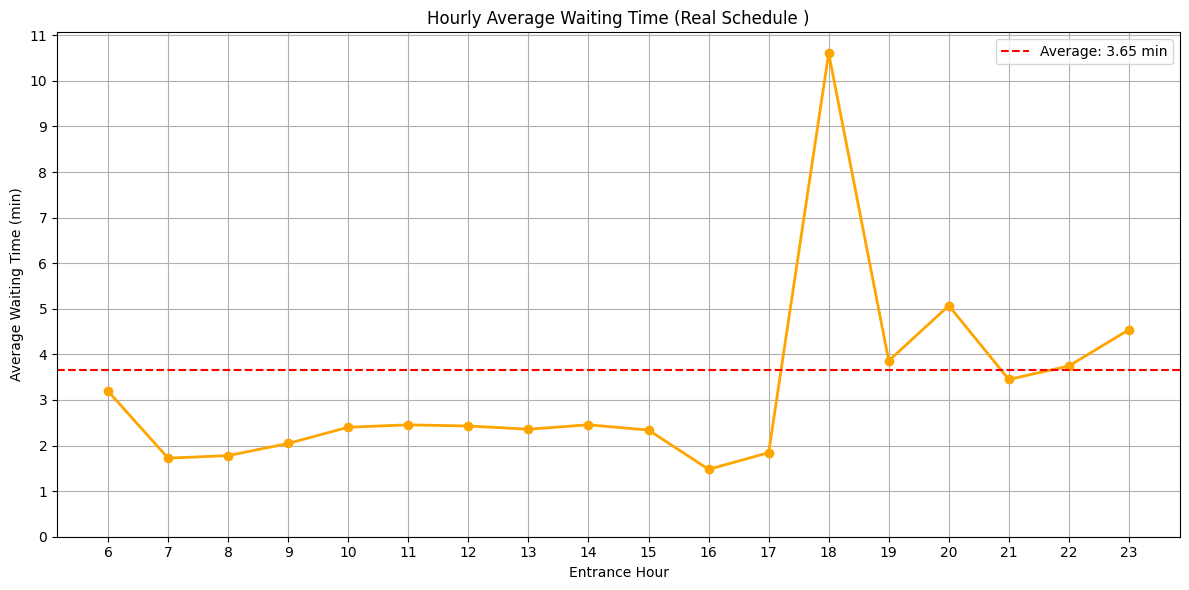

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("UPDATED_PASSENGER_LIST.csv")

df["entrance_time"] = pd.to_datetime(df["enterance_time"], format="%H:%M:%S")

df["hour"] = df["entrance_time"].dt.hour

hourly_avg = df.groupby("hour")["wait_duration_min"].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg.values, color='orange', marker='o', linewidth=2)
plt.axhline(y=3.65, color='red', linestyle='--', label='Average: 3.65 min')
plt.title("Hourly Average Waiting Time (Real Schedule )")
plt.xlabel("Entrance Hour")
plt.ylabel("Average Waiting Time (min)")
plt.xticks(range(6, 24)) 
plt.yticks(range(0,12))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

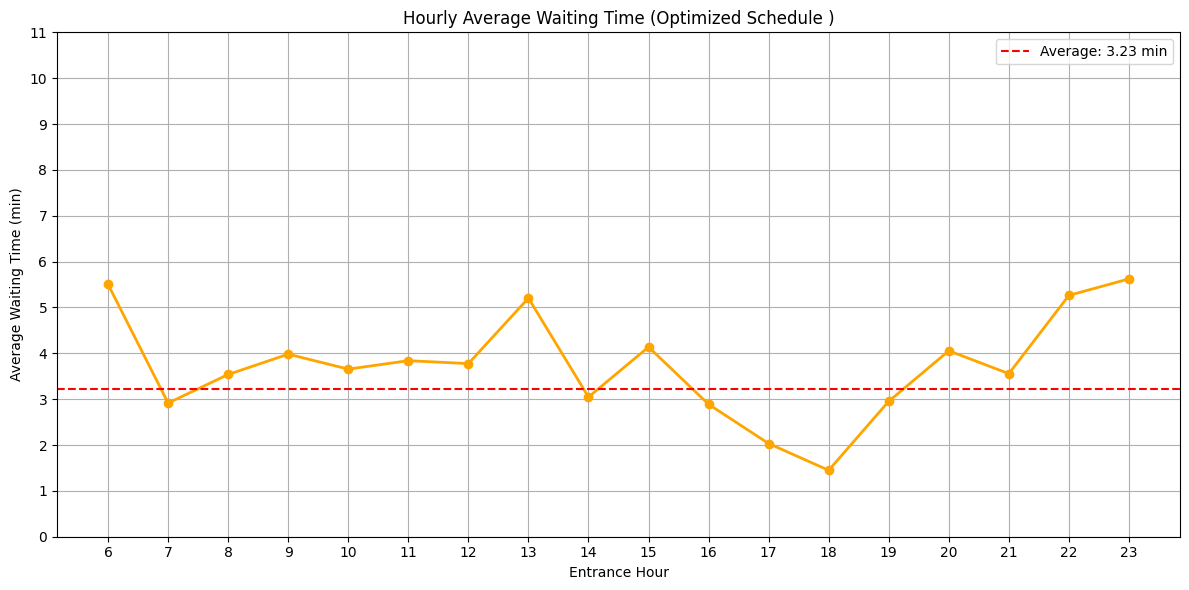

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("OPTIMIZED_PASSENGER_LIST_SON.csv")

df["entrance_time"] = pd.to_datetime(df["enterance_time"], format="%H:%M:%S")

df["hour"] = df["entrance_time"].dt.hour

hourly_avg = df.groupby("hour")["wait_duration_min"].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg.values, color='orange', marker='o', linewidth=2)
plt.axhline(y=3.23, color='red', linestyle='--', label='Average: 3.23 min')
plt.title("Hourly Average Waiting Time (Optimized Schedule )")
plt.xlabel("Entrance Hour")
plt.ylabel("Average Waiting Time (min)")
plt.xticks(range(6, 24))
plt.yticks(range(0,12))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

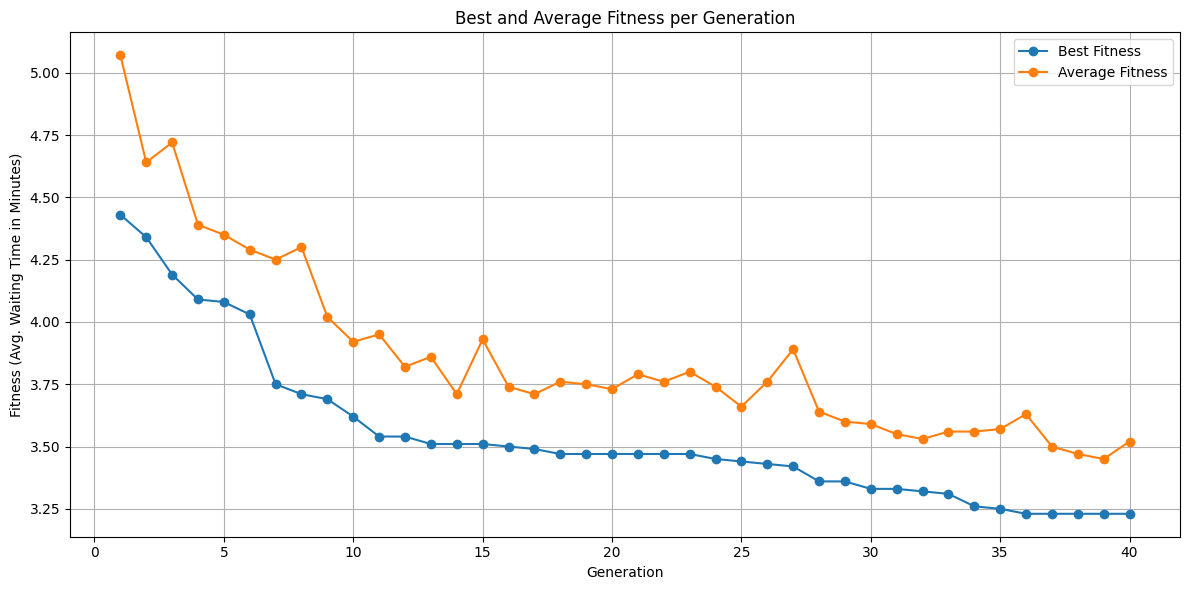

In [1]:
import matplotlib.pyplot as plt

generations = list(range(1, 41))
best_fitness = [
    4.43, 4.34, 4.19, 4.09, 4.08, 4.03, 3.75, 3.71, 3.69, 3.62,
    3.54, 3.54, 3.51, 3.51, 3.51, 3.50, 3.49, 3.47, 3.47, 3.47,
    3.47, 3.47, 3.47, 3.45, 3.44, 3.43, 3.42, 3.36, 3.36, 3.33,
    3.33, 3.32, 3.31, 3.26, 3.25, 3.23, 3.23, 3.23, 3.23, 3.23
]

avg_fitness = [
    5.07, 4.64, 4.72, 4.39, 4.35, 4.29, 4.25, 4.30, 4.02, 3.92,
    3.95, 3.82, 3.86, 3.71, 3.93, 3.74, 3.71, 3.76, 3.75, 3.73,
    3.79, 3.76, 3.80, 3.74, 3.66, 3.76, 3.89, 3.64, 3.60, 3.59,
    3.55, 3.53, 3.56, 3.56, 3.57, 3.63, 3.50, 3.47, 3.45, 3.52
]

plt.figure(figsize=(12, 6))
plt.plot(generations, best_fitness, marker='o', label='Best Fitness')
plt.plot(generations, avg_fitness, marker='o', label='Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness (Avg. Waiting Time in Minutes)')
plt.title('Best and Average Fitness per Generation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()